In [1]:
%matplotlib inline
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
from bs4 import BeautifulSoup
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.ensemble import ExtraTreesClassifier

In [2]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
py.init_notebook_mode(connected = True)

In [3]:
train = pd.read_csv('Data/mbti_1.csv')
us = pd.read_csv('Data/Users.csv')
ps = pd.read_csv('Data/ForumMessages.csv')
mbti = {'I' : 'Introversion', 'E' : 'Extroversion', 'N' : 'Intutions', 'S' : 'Sensing', 'T' : 'Thinking', 'F' : 'Feeling', 'J': 'Judging', 'P' : 'Perceiving'}

In [4]:
train.shape

(8675, 2)

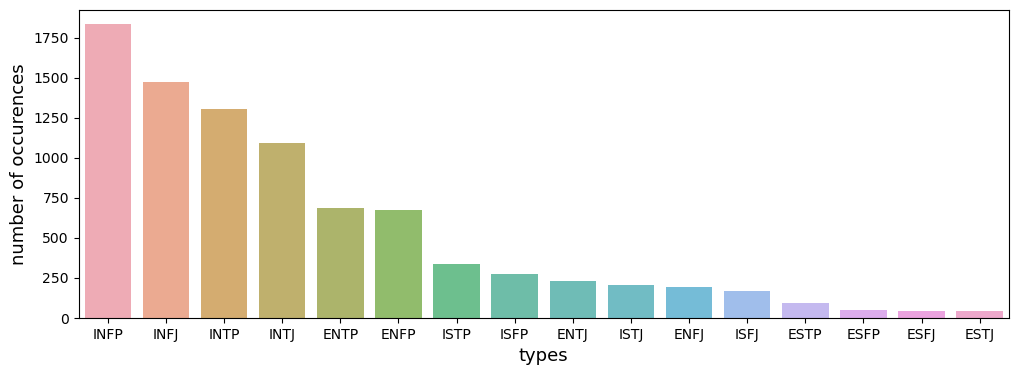

In [5]:
cnt_srs = train['type'].value_counts()
plt.figure(figsize = (12,4))
sns.barplot(y = cnt_srs.values, x = cnt_srs.index, alpha=0.8)
plt.ylabel('number of occurences', fontsize = 13)
plt.xlabel('types', fontsize = 13)
plt.show()

In [6]:
ps['Message'] = ps['Message'].fillna('')

In [7]:
ps_join = ps.groupby('PostUserId')['Message'].agg(lambda col : ' '.join(col)).reset_index()

In [8]:
etc = ExtraTreesClassifier(n_estimators = 20, max_depth = 4, n_jobs = -1)
tfidf = TfidfVectorizer(ngram_range = (1,1), stop_words = 'english')
tsvd = TruncatedSVD(n_components =10)
model = Pipeline([('tfidfi',tfidf),('tsvd1',tsvd),('etc',etc)])

In [9]:
kfolds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1)

In [10]:
np.random.seed(1)

scoring = {'acc' : 'accuracy',
          'neg_log_loss' : 'neg_log_loss',
          'f1_micro' : 'f1_micro'}

results = cross_validate(model, train['posts'], train['type'], cv = kfolds,
                        scoring = scoring, n_jobs = -1)


In [11]:
print("CV Accuracy: {:0.4f}(+/- {:0.4f})".format(np.mean(results['test_acc']),
                                                np.std(results['test_acc'])))
print("CV F1: {:0.4f}(+/- {:0.4f})".format(np.mean(results['test_f1_micro']),
                                                np.std(results['test_f1_micro'])))
print("CV Logloss: {:0.4f}(+/- {:0.4f})".format(np.mean(results['test_neg_log_loss']),
                                                np.std(results['test_neg_log_loss'])))

CV Accuracy: 0.2972(+/- 0.0109)
CV F1: 0.2972(+/- 0.0109)
CV Logloss: -2.1371(+/- 0.0153)


In [12]:
def cleanText(text):
    text = BeautifulSoup(text, 'lxml').text
    text = re.sub(r'\|\|\|',r'',text)
    text = re.sub(r'http\S+', r'<URL>',text)
    return text
                  

In [13]:
train['clean_posts'] = train['posts'].apply(cleanText)

C:\Users\msi\AppData\Local\Temp\ipykernel_25140\2928371277.py:2: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



In [14]:
print(repr(train.columns))

Index(['type', 'posts', 'clean_posts'], dtype='object')


In [15]:
np.random.seed(1)

tfidf2 = CountVectorizer(ngram_range=(1,1),
                        stop_words='english',
                        lowercase = True,
                        max_features = 5000)

model_nb = Pipeline([('tfidf1', tfidf2), ('nb', MultinomialNB())])

results_nb = cross_validate(model_nb, train['clean_posts'], train['type'], cv=kfolds,
                           scoring=scoring, n_jobs = -1)

In [16]:
print("CV Accuracy: {:0.4f}(+/- {:0.4f})".format(np.mean(results_nb['test_acc']),
                                                np.std(results_nb['test_acc'])))

print("CV F1: {:0.4f}(+/- {:0.4f})".format(np.mean(results_nb['test_f1_micro']),
                                                np.std(results_nb['test_f1_micro'])))

print("CV Logloss: {:0.4f}(+/- {:0.4f})".format(np.mean(-1*results_nb['test_neg_log_loss']),
                                                np.std(-1*results_nb['test_neg_log_loss'])))

CV Accuracy: 0.5627(+/- 0.0110)
CV F1: 0.5627(+/- 0.0110)
CV Logloss: 6.2055(+/- 0.3766)


In [17]:
np.random.seed(1)

tfidf2 = CountVectorizer(ngram_range=(1,1), stop_words='english',
                                                lowercase = True, max_features = 5000)

model_lr = Pipeline([('tfidf1',tfidf2), ('lr',LogisticRegression(class_weight="balanced", C=0.005))])

results_lr = cross_validate(model_lr, train['clean_posts'], train['type'], cv=kfolds, 
                           scoring=scoring, n_jobs=-1)


In [18]:
print("CV Accuracy: {:0.4f} (+/- {:0.4f})".format(np.mean(results_lr['test_acc']),
                                                 np.std(results_lr['test_acc'])))

print("CV F1: {:0.4f} (+/- {:0.4f})".format(np.mean(results_lr['test_f1_micro']),
                                           np.std(results_lr['test_f1_micro'])))

print("CV LogLoss: {:0.4f} (+/- {:0.4f})".format(np.mean(-1*results_lr['test_neg_log_loss']),
                                                np.std(-1*results_lr['test_neg_log_loss'])))


CV Accuracy: 0.6561 (+/- 0.0138)
CV F1: 0.6561 (+/- 0.0138)
CV LogLoss: 1.3072 (+/- 0.0131)


In [19]:
train_sizes, train_scores, test_scores = \
    learning_curve(model_lr, train['clean_posts'], train['type'], cv=kfolds, n_jobs=-1,
                  scoring = 'f1_micro', train_sizes = np.linspace(.1,1.0,10), random_state = 1)

In [20]:
def plot_learning_curve(X, y, train_sizes, train_scores, test_scores, title='', ylim=None, figsize=(14,8)):
    
    plt.figure(figsize=figsize)
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1,
                    color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color ="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color = "r",
            label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color = "g",
            label = "Cross-validation score")
    
    plt.legend(loc = "best")
    return plt


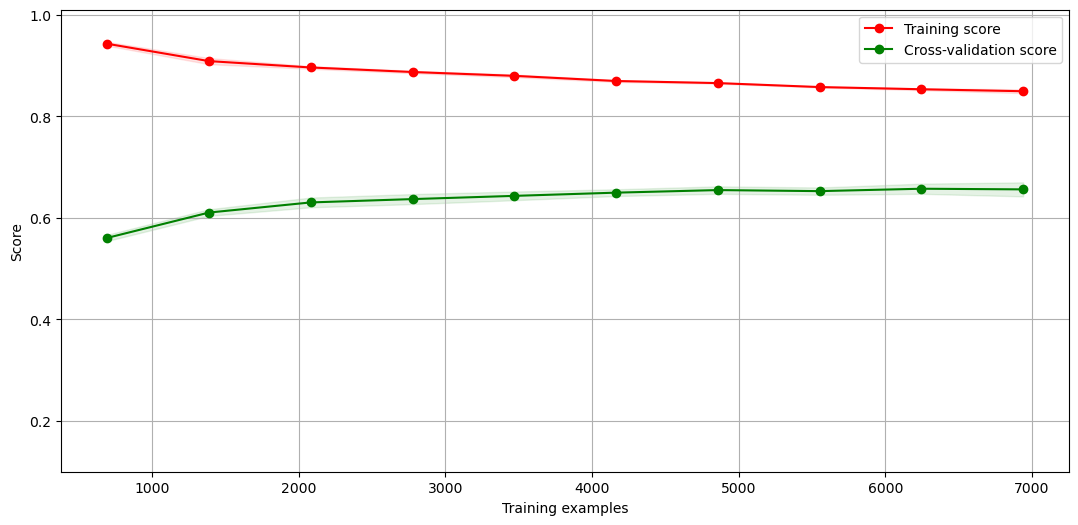

In [21]:
plot_learning_curve(train['posts'],train['type'],train_sizes,
                   train_scores, test_scores, ylim=(0.1,1.01), figsize=(13,6))
plt.show()

In [22]:
ps_join['clean_comments']= ps_join['Message'].apply(cleanText)

In [23]:
model_lr.fit(train['clean_posts'], train['type'])
pred_all = model_lr.predict(ps_join['clean_comments'])

c:\Users\msi\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



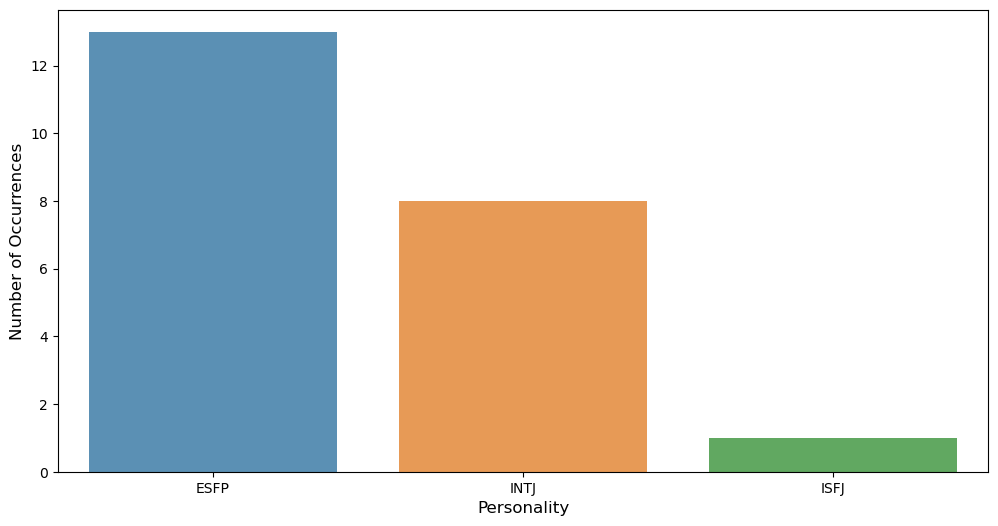

In [24]:
cnt_all = np.unique(pred_all, return_counts=True)

pred_df = pd.DataFrame({'personality': cnt_all[0],'count': cnt_all[1]},
                      columns=['personality', 'count'], index=None)

pred_df.sort_values('count',ascending=False, inplace=True)

plt.figure(figsize=(12,6))
sns.barplot(x=pred_df['personality'], y=pred_df['count'], alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Personality',fontsize=12)
plt.show()


In [25]:
pred_df['percent']=pred_df['count']/pred_df['count'].sum()

In [26]:
pred_df['description']= pred_df['personality'].apply(lambda x: " ".join([mbti[l] for l in list(x)]))

In [27]:
pred_df

,personality,count,percent,description
0,ESFP,13,0.590909,Extroversion Sensing Feeling Perceiving
1,INTJ,8,0.363636,Introversion Intutions Thinking Judging
2,ISFJ,1,0.045455,Introversion Sensing Feeling Judging


In [29]:
labels = pred_df['description']
sizes = pred_df['percent']*100

trace = go.Pie(labels = labels, values= sizes)
layout = go.Layout(
     title='Personality Prediction Distribution via CV Analysis')

data = [trace]
fig = go.Figure(data= data, layout = layout)
py.iplot(fig)